# Introduction to Machine Learning via Nearest Neighbours


## Part 1 - Implement k-Nearest Neighbours (kNN) - 30 points

### Note:
This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.
### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nurdes: use kd-tree for efficiency, see [nearest neighbour search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nurdes: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
  def fit(self, X, y):
    self.X = X
    self.y = y
  def predict(self, X):
    euclidean_dist = np.sqrt(((self.X - np.expand_dims(X, axis=1))**2).sum(axis=-1)) # calc L2 dist
    nearest_neighbours = np.argsort(euclidean_dist, axis=1)[:,:self.n_neighbors] # return k nearest points
    nearest_neighbours_labels = self.y[nearest_neighbours] # return k nearest labels
    counter = [Counter(nearest_neighbours_labels[k, :]) for k in range(nearest_neighbours_labels.shape[0])]
    return np.array([c.most_common(1)[0][0] for c in counter])
  

## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

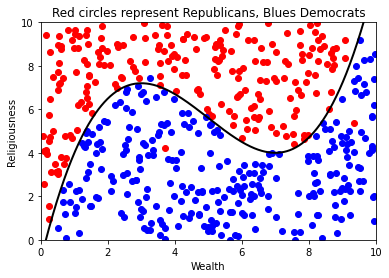

In [4]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)


### 1. Analyse the properties of kNN - 30 points
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision plane](https://doc-14-14-docs.googleusercontent.com/docs/securesc/flg80o8vb463a3nd3i6da8hemig5me1b/hvii8ll4dscju8o17vuo2aab9aei8hgr/1543334400000/11934753179242311747/03422859225809857490/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw?e=view&nonce=4i4j8lssjk6kc&user=03422859225809857490&hash=k9ogjg94ssot1vocu8uoeg4okkeekg6f)

https://drive.google.com/file/d/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw/view?usp=sharing

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?

* Bonus for nurdes:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

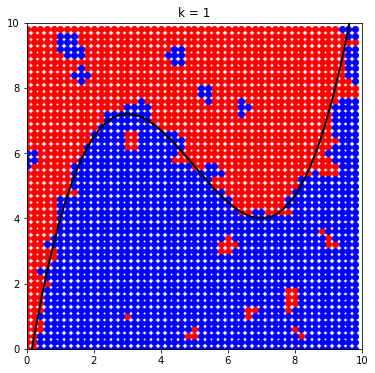

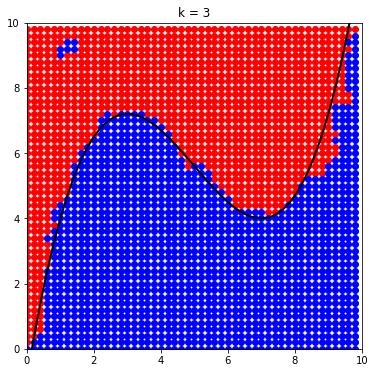

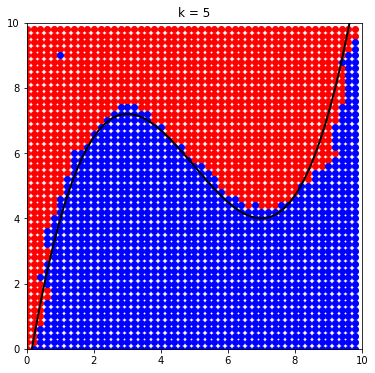

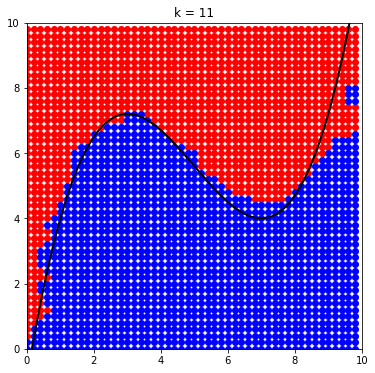

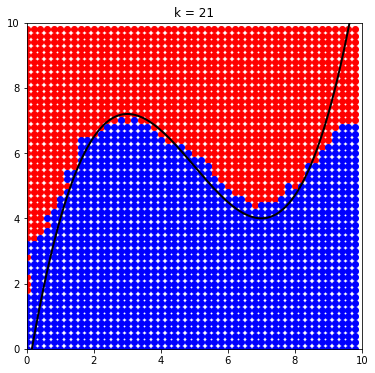

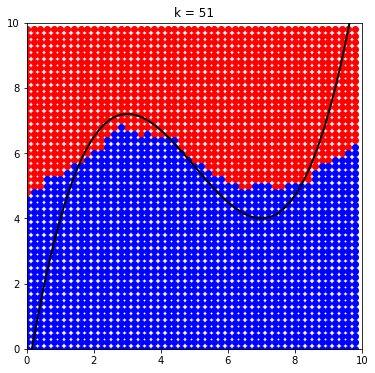

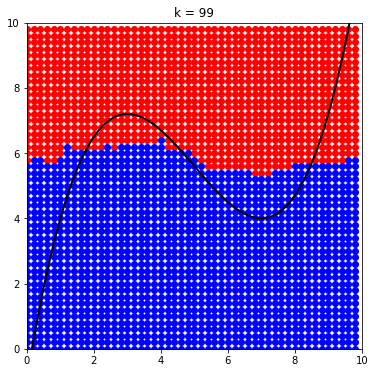

In [5]:
def get_grid_coordinates(xmin=0, xmax=10, ymin=0, ymax=10, step_size=0.2):
  """Returns coordinate matrix."""
  xx, yy = np.meshgrid(np.arange(xmin, xmax, step_size), np.arange(ymin, ymax, step_size))
  return np.c_[xx.ravel(),yy.ravel()]

X, y = generate_data(m=500)
X_grid = get_grid_coordinates()
for k in [1,3,5,11,21,51,99]:
    kNN = kNNClassifier(k)
    kNN.fit(X, y)
    plt.figure(figsize=(6, 6))
    plot_labeled_data(X_grid, kNN.predict(X_grid), no_titles=True)
    plt.title(f"k = {k}")

#### How is the decision plain affected from changes in the sample set, as a function of k?
- For small k, different sample sets present as very different decision planes,
but for large k, the decision plane is not impacted much by the sample set.


#### Can you describe when do you underfit or overfit the data?

- When k is too small, the model is overfit, as there are islands corresponding to outliers in the training data.
- When k is large, the model is underfit and the model does not match the decision boundary well.
- The best k seems to be in the 5 to 11 range.

#### How does the complexity of this model depends on k?
- The complexity is reduced as k increases, however the computation time increases with k.


### 2. Finding the optimal k - 15 points
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on test? is the optimal k the same?


In [6]:
# Define error metric function
def error_metric(y_true, y_pred) -> float:
  accuracy = metrics.accuracy_score(y_true, y_pred)
  return 1.0 - accuracy

In [7]:
X, y = generate_data(m=1000)
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

(1000, 2)


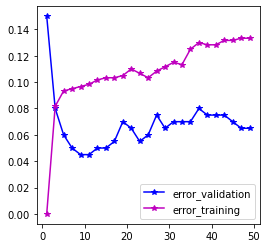

In [8]:
ks = np.arange(1, 50, 2)
error_training = []
error_validation = []

for k in ks:
    kNN = kNNClassifier(k)
    kNN.fit(X_train, y_train) 
    predict_validation = kNN.predict(X_validation)
    predict_training = kNN.predict(X_train)
    error_validation.append(error_metric(y_validation, predict_validation))
    error_training.append(error_metric(y_train, predict_training))

plt.figure(figsize=(4, 4))
plt.plot(ks, error_validation,'b*-')  
plt.plot(ks, error_training,'m*-')  
plt.legend(["error_validation", "error_training"], loc ="lower right")

In [9]:
# choose optimal K 
opt_k_ind = np.argmin(error_validation)
opt_k_ind
print("opt_k:", ks[opt_k_ind])

opt_k: 9


##### Where do you underfit/overfit the data?

* The model is overfit at k=1, and underfit with k over about 19

##### Estimate the generalization error of your chosen classifier using the test set. 

In [10]:
# generelization error - on test set:
k = ks[opt_k_ind] # min error on validation set
kNN = kNNClassifier(k)
kNN.fit(X_train, y_train) 
predict_test = kNN.predict(X_test)
error_test = error_metric(y_test, predict_test)
print("Error_test", error_test)

Error_test 0.10499999999999998


##### What would happen if you optimize directly on test? is the optimal k the same?

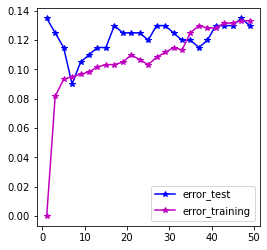

In [11]:
# optimize k using the test set instead of validation set:
ks = np.arange(1, 50, 2)
error_training = []
error_test = []

for k in ks:
    kNN = kNNClassifier(k)
    kNN.fit(X_train, y_train) 
    predict_test = kNN.predict(X_test)
    predict_training = kNN.predict(X_train)
    error_test.append(error_metric(y_test, predict_test))
    error_training.append(error_metric(y_train, predict_training))
plt.figure(figsize=(4, 4))
plt.plot(ks, error_test,'b*-')  
plt.plot(ks, error_training,'m*-')  
plt.legend(["error_test", "error_training"], loc ="lower right")

In [12]:
# choose optimal K:
opt_k_ind = np.argmin(error_test)
opt_k_ind
print("opt_k:", ks[opt_k_ind])

opt_k: 7


### 3. Using cross validation - 25 points
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [14]:
X, y = generate_data(m=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [15]:
k_sweep = list(range(1, 31))
folds = 5
scores = np.zeros((len(k_sweep), folds))

fold_ind = 0
for train_ind, test_ind in KFold(folds, shuffle=False).split(X_train, y_train):
  X_train_fold = X_train[train_ind, :]
  y_train_fold = y_train[train_ind]
  X_test_fold = X_train[test_ind, :]
  y_test_fold = y_train[test_ind]
  print(f"Train set size: {len(y_train_fold)}")
  print(f"Validation set size: {len(y_test_fold)}")

  for k_ind, k in enumerate(k_sweep):
    model = kNNClassifier(k)
    model.fit(X_train_fold, y_train_fold)
    predictions = model.predict(X_test_fold)
    scores[k_ind, fold_ind] = error_metric(y_test_fold, predictions)

  fold_ind += 1

scores_per_k = scores.mean(axis=1)
best_k_ind = scores_per_k.argmin()
best_k = k_sweep[best_k_ind]
print(f"Best k = {best_k}")
print(f"CV error = {scores_per_k[best_k]}")

model = kNNClassifier(best_k)
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)
test_score = error_metric(y_test, test_predictions)
print(f"Test score: {test_score}")


Train set size: 640
Validation set size: 160
Train set size: 640
Validation set size: 160
Train set size: 640
Validation set size: 160
Train set size: 640
Validation set size: 160
Train set size: 640
Validation set size: 160
Best k = 4
CV error = 0.045
Test score: 0.040000000000000036


In [17]:
# Same thing using sklearn
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
gridsearch.fit(X_train, y_train)
print("Best Parameter:", gridsearch.best_params_)
print("Best CV Error: ", 1 - gridsearch.best_score_)
y_pred = gridsearch.predict(X_test)
print(f'Test Error: {error_metric(y_test, y_pred)}')

Best Parameter: {'n_neighbors': 3}
Best CV Error:  0.043749999999999956
Test Error: 0.040000000000000036


##### What is the size of the validation and train set now, in each CV iteration? 
- Size of the validation is 80%(1000) *1/5 = 160
- Size of train set is 80%(1000) *4/5 = 640

##### Did your final model selection change? Explain why.
The final model selection changed since by using cross-validation, we chose a model that is lower variance and higher bias (higher k and less complex)

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html